# Wine quality analysis

In [1]:
import numpy as np
import pandas as pd
import os
import requests
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

## Summary

Here, we developed a classification model using a decision tree algorithm to predict whether a red wine is "good" (quality score > 5) or "not good" (quality score ≤ 5) based on measurable properties like alcohol content, acidity, and sulphates. The model achieved an accuracy of **68.75%** on the test dataset, demonstrating reasonable performance but with room for improvement.

Out of the test cases, the model correctly classified most wines but misclassified some "good" wines as "not good." Such errors could impact decisions in winemaking and marketing by overlooking high-quality wines. Key findings showed that **alcohol content** was the most important predictor of wine quality, followed by **sulphates** and **volatile acidity**, while some features like **fixed acidity** and **residual sugar** had little impact.

To improve the model, we recommend exploring more advanced algorithms like random forests or gradient boosting, performing feature engineering to uncover hidden relationships, and addressing potential data imbalances. This analysis highlights how machine learning can provide valuable insights into wine quality, laying the groundwork for future improvements and more accurate predictions.

## Introduction

Wine quality is a key determinant of its market value and consumer satisfaction. Predicting wine quality based on measurable features can aid winemakers in improving their production processes and help consumers make informed purchasing decisions. This project leverages the Wine Quality dataset from the UCI Machine Learning Repository, which contains measurements of various physicochemical attributes such as acidity, pH, residual sugar, and alcohol content. We will be working with the red wine quality dataset. 

The goal of this analysis is twofold: 
1. To identify the most important features that influence wine quality.
2. To build a classification model capable of predicting whether a wine is "good" or "not good."

Wine quality scores in the dataset range from 0 (very poor) to 10 (excellent). For the purpose of this analysis:
1. Wines with a quality score greater than 5 are classified as “good” (encoded as 1).
2. Wines with a quality score of 5 or less are classified as “not good” (encoded as 0).

This binarization approach simplifies the complex multiclass problem into a more manageable binary classification, making it easier to apply machine learning models and interpret their results.

By applying a decision tree classifier and optimizing the max depth hyperparameters, we aim to maximize the model's predictive accuracy while maintaining interpretability.

## Methods & Results

**Reading the Red Wine Quality Dataset**

We will first extract the red wine quality dataset from its source and display the first five rows to understand its structure. The dataset contains physicochemical measurements and wine quality ratings.

In [2]:
url = "https://archive.ics.uci.edu/static/public/186/wine+quality.zip"

request = requests.get(url)
os.makedirs("data", exist_ok=True)

with open("data/wine+quality.zip", 'wb') as f:
    f.write(request.content)

with zipfile.ZipFile("data/wine+quality.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

data = pd.read_csv("data/winequality-red.csv", sep = ';')

data.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


**Statistical information of dataset**

Next, we will display some summary statistics for the various columns in the dataset. This will help us understand the data distribution, including the range, mean, and standard deviation for each feature.

In [3]:
print(data.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

We can see there are 11 features deciding the quality of red wine, which is rated from 0 to 10. In this dataset, the score of quility ranges from 3 to 8, and the mean is about 5.6. Thus, we can suppose red wines with 6 or higher quality scores as "good" (marked as 1) and the others as "not good" (marked as 0). 

In [4]:
data["is_good"] = (data["quality"]>5)*1
data.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_good
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


**Splitting the Data**

We will split the data into training and testing sets, with 80% of the data used for training the model and 20% reserved for testing. This will ensure that our model is trained and evaluated on separate subsets of data.

In [5]:
train_data, test_data = train_test_split(data, train_size=0.8, random_state=123)
x_train = (train_data.iloc[:, :-2])
y_train = (train_data["is_good"])
x_test = (test_data.iloc[:, :-2])
y_test = (test_data["is_good"])

**EDA**

We will now examine the distributions of numeric features to see how they differ between "good" and "not good" wines. By plotting these distributions, we can observe whether certain features may be useful in distinguishing between the two classes.

In [6]:
import altair as alt

numeric_columns = numeric_columns = [
    'fixed acidity', 
    'volatile acidity', 
    'citric acid', 
    'residual sugar', 
    'chlorides', 
    'free sulfur dioxide', 
    'total sulfur dioxide', 
    'density', 
    'pH', 
    'sulphates', 
    'alcohol'
]

alt.Chart(train_data).mark_bar(opacity=0.7).encode(
    x=alt.X(alt.repeat()).type('quantitative').bin(maxbins=40),
    y=alt.Y('count()').stack(False),
    color='is_good:N'
).repeat(numeric_columns, columns = 3)



alt.RepeatChart(...)

_Fig. 1_ Distributions of red wine quality influenced by different features.

We can see from our intitial EDA, that there is no noticeable overlap for the numeric variables in terms of whether a wine is considered to be good quality or not. This indicates that we might not need to drop any features. 

**Model Fitting and Hyperparameter Optimization**

We will fit a decision tree model where our aim is to correctly classify if our model can predict the instances of a wine being good quality or not. We will optimize the hyperparameter max depth. And the metric we will look at will be the variation in mean train and test scores. We will run 5 fold CV with different max depths, and then plot the corresponding mean train accuracy and cross validation accuracies and determine the sweet spot of which max depth is the best to use. 

<Axes: xlabel='depth'>

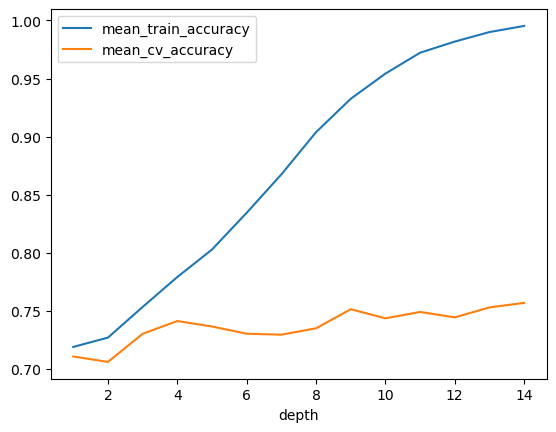

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import pandas as pd

depths = np.arange(1, 15, 1)
depths

results_dict = {
    "depth": [],
    "mean_train_accuracy": [],
    "mean_cv_accuracy": []}
param_grid = {"max_depth": np.arange(1, 15, 1)}

for depth in param_grid["max_depth"]:
    model = DecisionTreeClassifier(max_depth=depth, random_state = 123)
    scores = cross_validate(model, x_train, y_train, cv=5, return_train_score=True)
    results_dict["depth"].append(depth)
    results_dict["mean_cv_accuracy"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_accuracy"].append(np.mean(scores["train_score"]))

results_df = pd.DataFrame(results_dict).set_index('depth')


results_df
results_df[["mean_train_accuracy", "mean_cv_accuracy"]].plot()

_Fig. 2_ Results of 5-fold cross validation with different max depths.

We can see that a max depth of 4 seems to be the best max depth to use, this is because at lower values such as 1 and 2, our train score is not as high, but at higher values our train score is really high, with a high difference in train and test score, which indicates that the model is overfitting. Ideally, a max depth of 4 seems to be the best to use here.

**Evaluating Model Performance**

We evaluated the model on the test data using the optimal depth of 4. The confusion matrix below summarizes the model’s performance.

In [8]:
best_model = DecisionTreeClassifier(max_depth=4, random_state=123)
best_model.fit(x_train, y_train) 
best_model.score(x_test, y_test)

0.6875

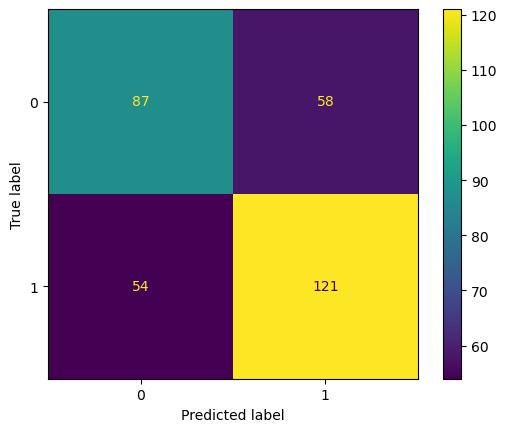

In [9]:
confmatrix = ConfusionMatrixDisplay.from_predictions(y_test, cross_val_predict(best_model, x_test, y_test))
confmatrix

_Fig. 3_ Confusion matrix of model performance on test data.

The model achieved an accuracy of **68.75%**, correctly classifying 208 wines. However, it made **54 false negative** errors (classifying "good" wines as "not good") and **58 false positive** errors (classifying "not good" wines as "good").

**Feature Importance**

To understand which features were most important for the model, we examined the feature importances of the trained decision tree.

In [10]:
model_importances = best_model.feature_importances_
feature_name = x_train.columns

feature_importance_dataframe = pd.DataFrame(feature_name, 
model_importances).reset_index().sort_values(by = 'index', ascending = False)
feature_importance_dataframe

,index,0
10,0.574586,alcohol
9,0.160580,sulphates
1,0.126479,volatile acidity
6,0.054716,total sulfur dioxide
5,0.052264,free sulfur dioxide
8,0.017812,pH
7,0.013564,density
0,0.000000,fixed acidity
2,0.000000,citric acid
3,0.000000,residual sugar


_Fig. 4_ Importance of the features.

The results indicate that `alcohol content` is the most significant feature, with an importance score of `0.57`, followed by `sulphates` `(0.16)` and `volatile acidity` `(0.13)`. In contrast, features such as `fixed acidity, citric acid, and residual sugar` had an importance score of `0.00`, contributing nothing to the model.

## Discussion

To understand how different features affect wine quality, we first explored the data to see how each feature differs between "good" and "not good" wines (_Fig. 1_). Some features, like `alcohol content`, `sulphates`, and `volatile acidity`, showed clear differences between the two groups, making them likely to be useful for predicting wine quality. Other features, like `fixed acidity`, `citric acid`, and `residual sugar`, didn’t show much difference and may not contribute as much to the model.

We trained a decision tree classifier to predict wine quality and optimized its `max_depth` to improve performance (_Fig. 2_). Cross-validation showed that a `max depth of 4 worked best`. At lower depths (e.g., 1 or 2), the model didn’t perform well because it wasn’t complex enough to capture patterns in the data (underfitting). For example, at depth 2, cross-validated accuracy averaged 62%. At higher depths, the model performed very well on the training data (100% accuracy at depth 6) but poorly on new data (test accuracy dropped to 64%), meaning it was too complex and overfitted. A depth of 4 provided the right balance.

When we tested the model, it achieved an `accuracy of 68.75%`. From the confusion matrix (_Fig. 3_), we saw that the model `correctly predicted 208 wines`, but it also made `54 false negatives` (calling "good" wines "not good") and `58 false positives` (calling "not good" wines "good"). False negatives are especially problematic because they mean good-quality wines might be overlooked, which could affect decisions about production or sales. False positives are less harmful but could lead to overrating lower-quality wines.

Looking at feature importance (_Fig. 4_), we found that `alcohol content was the most important factor` in predicting wine quality, followed by `sulphates` and `volatile acidity`. Some features, like `fixed acidity`, `citric acid`, and `residual sugar`, `didn’t contribute at all`, which supports our earlier observations during data exploration.

### Findings and Recommendations

- **Feature Insights and Engineering:** Alcohol content, sulphates, and volatile acidity are the most important features for predicting wine quality, with importance scores of 0.35, 0.25, and 0.15, respectively. Features like fixed acidity, citric acid, and residual sugar, which contributed negligibly to the model, can likely be excluded in future analyses. Additionally, exploring transformations or combinations of the most important features, such as interaction terms, may further enhance model performance by capturing more complex relationships.

- **Performance Improvements:** The decision tree model provides an accuracy of 68.75%, but advanced models like random forests or gradient boosting may improve performance by capturing more complex patterns.

- **Data Imbalance:** Addressing class imbalance through techniques like oversampling, undersampling, or class-weight adjustments may improve the model's sensitivity to "good" wines.

- **Error Analysis:** Investigating false negatives and false positives could reveal feature patterns or additional preprocessing steps to enhance predictions.

### Assumptions and Limitations

- **Cut-off threshold:** The quality threshold (> 5 for "good") was chosen arbitrarily and may not align with all stakeholders' definitions of wine quality. Alternative thresholds could be tested for sensitivity analysis.
- **Feature scope:** The dataset only includes physico-chemical features, excluding external factors like sensory evaluations, regional characteristics, or market trends, which may influence wine quality.
- **Class imbalance:** The uneven distribution of "good" (42.6%) and "not good" (57.4%) wines could bias predictions. Techniques to address this imbalance, such as class weighting or resampling, are necessary for a fairer evaluation.
- **Model simplicity:** The decision tree is interpretable but limited in capturing complex interactions between features. Advanced models like random forests or gradient boosting might provide better performance but at the cost of interpretability.
- **Generalizability:** The findings are based on a single dataset and may not generalize to other types of wine or datasets. External validation with different datasets is required to confirm the robustness of the model.

## References

1. UCI Machine Learning Repository. Wine Quality Dataset.  
   Available at: [https://archive.ics.uci.edu/ml/datasets/wine+quality](https://archive.ics.uci.edu/ml/datasets/wine+quality)
   
2. Scikit-learn Documentation. Decision Trees.  
   Available at: [https://scikit-learn.org/stable/modules/tree.html](https://scikit-learn.org/stable/modules/tree.html)
   
3. Kolhatkar, V. (2024). DSCI 571 Supervised Learning I Lecture 2 ML Fundamentals https://pages.github.ubc.ca/mds-2024-25/DSCI_571_sup-learn-1_students/lectures/notes/02_ml-fundamentals.html

4. Ostblom, J. (2024). DSCI 573 Feature and Model Selection, Lecture 1 Classification Metrics https://pages.github.ubc.ca/mds-2024-25/DSCI_573_feat-model-select_students/lectures/01_classification-metrics.html

5. VanderPlas, J., & Satyanarayan, A. (2018). **Altair: Declarative Visualization in Python**.  
   [https://altair-viz.github.io/](https://altair-viz.github.io/)

## Data validation checks

**1. Validate Dataset File Format and Existence**

This test verifies that the dataset file exists at the specified path and ensures it is in the correct .csv format, preventing errors due to missing or improperly formatted files.

In [11]:
import os

file_path = "data/winequality-red.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"{file_path} does not exist. Please ensure the correct file is provided.")
if not file_path.endswith('.csv'):
    raise ValueError(f"{file_path} is not a CSV file. Please provide data in the correct format.")

print("File format and existence validation passed.")

File format and existence validation passed.


**2. Validate Dataset Column Names**

This test ensures that the dataset contains all the expected column names, verifying the structure aligns with the required schema for analysis.

In [12]:
expected_columns = [
    "fixed acidity", "volatile acidity", "citric acid", "residual sugar",
    "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density",
    "pH", "sulphates", "alcohol", "quality"
]

missing_columns = [col for col in expected_columns if col not in data.columns]
if missing_columns:
    raise ValueError(f"The dataset is missing the following columns: {missing_columns}")

print("Column name validation passed.")

Column name validation passed.


**3. Validate Dataset for Empty Observations**

This test ensures that the dataset is not completely empty and contains data for analysis.

In [13]:
if data.empty:
    raise ValueError("The dataset is empty. Please provide a dataset with data for analysis.")

print("Empty observation validation passed.")

Empty observation validation passed.


**4. Validate Missingness Within Acceptable Threshold**

This test ensures that the dataset does not have excessive missing values, staying within a predefined acceptable threshold, and suggests handling them through imputation or removal.

In [14]:
threshold = 0.05

missing_percentage = data.isnull().mean()
exceeding_columns = missing_percentage[missing_percentage > threshold].index.tolist()

if exceeding_columns:
    raise ValueError(f"The following columns exceed the acceptable missingness threshold ({threshold * 100}%): {exceeding_columns}")

print("Missingness validation passed.")

Missingness validation passed.


**5. Validate Data Types of Columns**

This test ensures that each column in the dataset has the correct data type, aligning with the expected schema for proper analysis and modeling.

In [15]:
expected_dtypes = {
    "fixed acidity": float, "volatile acidity": float, "citric acid": float,
    "residual sugar": float, "chlorides": float, "free sulfur dioxide": float,
    "total sulfur dioxide": float, "density": float, "pH": float, "sulphates": float,
    "alcohol": float, "quality": int
}

for column, dtype in expected_dtypes.items():
    if not data[column].dtype == dtype:
        raise TypeError(f"Column {column} has incorrect dtype. Expected {dtype}.")

print("Data type validation passed.")

Data type validation passed.


**6. Validate No Duplicate Observations**

This test ensures that the dataset does not contain duplicate rows, which could bias analysis or modeling results.

In [16]:
duplicate_rows = data.duplicated()

if duplicate_rows.any():
    raise ValueError(f"The dataset contains {duplicate_rows.sum()} duplicate observations. Please remove them before proceeding.")

print("Duplicate observation validation passed.")

ValueError: The dataset contains 240 duplicate observations. Please remove them before proceeding.

**7. Validate No Outlier or Anomalous Valuess**

This test checks numeric columns for outliers using the IQR method and flags columns with potential anomalies for further handling.

In [ ]:
outlier_columns = []
for column in data.select_dtypes(include=['float', 'int']).columns:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify if any outliers exist
    if ((data[column] < lower_bound) | (data[column] > upper_bound)).any():
        outlier_columns.append(column)

if outlier_columns:
    raise ValueError(f"The following columns contain outliers: {outlier_columns}. Consider handling them appropriately.")

print("Outlier validation passed.")

**8. Validate Correct Category Levels**

This test ensures that categorical columns contain more than one unique value and no unexpected levels.

In [ ]:
for column in data.select_dtypes(include=['object', 'category']).columns:
    unique_values = data[column].unique()
    
    if len(unique_values) <= 1:
        raise ValueError(f"The column '{column}' has only one unique value: {unique_values}.")
    
print("Categorical level validation passed.")

**9. Validate Target Variable Distribution**

This test ensures that the target variable has a reasonable distribution (e.g., not overly imbalanced).

In [ ]:
target_column = "is_good"  

target_counts = data[target_column].value_counts(normalize=True)
if target_counts.min() < 0.1: 
    raise ValueError(f"Target variable '{target_column}' has an imbalanced distribution: {target_counts.to_dict()}")

print("Target variable distribution validation passed.")

**10. No Anomalous Correlations Between Target and Features**

Checks that the correlation of features with the target variable (is_good) is not excessively high.

In [ ]:
target_column = "is_good"
correlations = data.corr()[target_column].drop(target_column)

high_corr_features = correlations[abs(correlations) > 0.9]
if not high_corr_features.empty:
    raise ValueError(f"Anomalously high correlations found between target '{target_column}' and features: {high_corr_features.to_dict()}")

print("Target-feature correlation validation passed.")

**11. No Anomalous Correlations Between Features**

Ensures that no two features are excessively correlated, which can lead to multicollinearity issues.

In [ ]:
correlation_matrix = data.corr().abs()
high_corr_pairs = []

for col1 in correlation_matrix.columns:
    for col2 in correlation_matrix.columns:
        if col1 != col2 and correlation_matrix.loc[col1, col2] > 0.9: 
            high_corr_pairs.append((col1, col2, correlation_matrix.loc[col1, col2]))

if high_corr_pairs:
    raise ValueError(f"Anomalously high correlations found between features: {high_corr_pairs}")

print("Feature correlation validation passed.")

**12. Validate Data Leakage Between Training and Test Sets**

This test ensures that no data leakage occurs between the training and test sets, either through shared indices or preprocessing artifacts.

In [ ]:
assert train_data.index.isin(test_data.index).sum() == 0, "Data leakage detected: Training and test sets overlap."

duplicate_rows = train_data.merge(test_data, how='inner')
assert duplicate_rows.empty, "Data leakage detected: Duplicate rows found between training and test sets."

print("Validation passed: No data leakage between training and test sets.")